# Table of Contents --> TBU

1. [Global parameters](#1-bullet) <br>
    <br>
    
2. [Loading datas](#2-bullet) <br>
    <br>

3. [Preprocessing](#3-bullet) <br>
    I - [Cleaning](#4-bullet) <br>
    II - [Split train/test and preprocessing](#5-bullet) <br>
    III - [Dimensionality reduction](#6-bullet) <br>
    IV - [Creation of folds for cv](#7-bullet) <br>
    <br>

4. [Model testing](#8-bullet) <br>
    I - [Dummy classifiers ](#9-bullet) <br>
    II - [Quick testing](#15-bullet) <br>
    III - [Linear models](#10-bullet) <br>
    VI - [KNN](#11-bullet) <br>
    V - [SVM](#12-bullet) <br>
    VI - [Trees and ensemblist methods](#13-bullet) <br>
    VII - [Neural networks](#14-bullet) <br>
    VIII - [Compare](#16-bullet) <br>
    <br>

5. [xx](#xx-bullet) <br>
    I - [xx](#xx-bullet) <br>
    II - [xx](#xx-bullet) <br>
    III - [xx](#xx-bullet) <br>
    IV - [xx](#xx-bullet) <br>
    V - [xx](#xx-bullet) <br>
    VI - [xx](#xx-bullet) <br>
    VII - [xx](#xx-bullet) <br>
    <br>

# 1. Global parameters <a class="anchor" id="1-bullet"></a>

In [198]:
# General input
random_state = 50 

# Cross-validation
optimized_metric = 'roc_auc' 
num_folds = 5
stratified = True

# 2. Loading datas <a class="anchor" id="2-bullet"></a>

In [199]:
# Classic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit
from contextlib import contextmanager

import warnings
from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Project specific functions
from P7_functions import *

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn import manifold, decomposition
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# Sklearn models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Neural networks
import tensorflow as tf

# Evaluation
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal
from sklearn.dummy import DummyClassifier

In [200]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [201]:
baseline_data = pd.read_csv('./Clean_datas/baseline_data.csv', sep=",")
data = pd.read_csv('./Clean_datas/clean_data_1.csv', sep=",")

In [202]:
data.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CURRENT_LOAN_LTV,CURRENT_LOAN_INCOME_CREDIT_PERC,CURRENT_LOAN_PAYMENT_RATE,TOTAL_AMT_ANNUITY,TOTAL_AMT_CREDIT,TOTAL_EFFORT_RATE,TOTAL_INCOME_CREDIT_PERC,TOTAL_PAYMENT_RATE,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON
0,0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,...,1.158397,0.498036,0.060749,247829.081500,888586.065,1.223847,0.227890,0.278903,0.067329,202500.0
1,1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,...,1.145199,0.208736,0.027598,292122.185803,2103502.500,1.081934,0.128357,0.138874,0.070862,135000.0
2,2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,...,1.000000,0.500000,0.050000,NaN,NaN,NaN,NaN,NaN,0.011814,67500.0
3,3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,...,1.052803,0.431748,0.094941,NaN,NaN,NaN,NaN,NaN,0.159905,67500.0
4,4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,...,1.000000,0.236842,0.042623,NaN,NaN,NaN,NaN,NaN,0.152418,121500.0


In [203]:
data.drop(['Unnamed: 0', 'SK_ID_CURR'], axis=1, inplace=True)

In [204]:
y = data['TARGET']
x = data.drop(['TARGET'], axis=1)
baseline_y = baseline_data['TARGET']
baseline_x = baseline_data.drop(['TARGET'], axis=1) # Note : categorical data already encoded

In [205]:
print(x.shape)
print(y.shape)

(307507, 399)
(307507,)


In [206]:
# Look targets breakdown
y.value_counts().apply(lambda x: x / y.count())

0    0.91927
1    0.08073
Name: TARGET, dtype: float64

We have very imbalanced classes, we will use StratifiedKFold for now. And see for SMOTE after

# 3. Preprocessing <a class="anchor" id="3-bullet"></a>

## I - Cleaning <a class="anchor" id="4-bullet"></a>

In [207]:
x.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,CURRENT_LOAN_LTV,CURRENT_LOAN_INCOME_CREDIT_PERC,CURRENT_LOAN_PAYMENT_RATE,TOTAL_AMT_ANNUITY,TOTAL_AMT_CREDIT,TOTAL_EFFORT_RATE,TOTAL_INCOME_CREDIT_PERC,TOTAL_PAYMENT_RATE,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON
count,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,252133.000000,307507.000000,307507.000000,...,307229.000000,307507.000000,307495.000000,2.163040e+05,2.163140e+05,216304.000000,216314.000000,216304.000000,252133.000000,3.075050e+05
mean,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,-16037.027271,-2384.142254,-4986.131376,-2994.201670,...,1.122994,0.399669,0.053695,9.411559e+05,1.926691e+06,5.708165,0.154313,0.609689,0.156860,9.310608e+04
std,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,0.013831,4363.982424,2338.327666,3522.883030,1509.454566,...,0.124036,0.507927,0.022481,5.921754e+06,2.459518e+06,33.373152,0.246091,3.542178,0.133548,1.013739e+05
min,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,...,0.150000,0.011801,0.022073,3.006000e+03,4.500000e+04,0.003830,0.000603,0.001404,-0.000000,2.812500e+03
25%,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-3175.000000,-7479.500000,-4299.000000,...,1.000000,0.193802,0.036900,9.718556e+04,7.524000e+05,0.640621,0.072865,0.093214,0.056098,4.725000e+04
50%,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1648.000000,-4504.000000,-3254.000000,...,1.118800,0.306272,0.050000,3.004183e+05,1.305000e+06,2.029257,0.116145,0.211615,0.118733,7.500000e+04
75%,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-767.000000,-2010.000000,-1720.000000,...,1.198000,0.495376,0.064043,7.142913e+05,2.254457e+06,4.373481,0.189675,0.395364,0.219167,1.125000e+05
max,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,0.000000,0.000000,0.000000,...,6.000000,208.003328,0.124430,6.802079e+08,3.356847e+08,3702.839475,95.097017,264.392053,0.728811,3.900000e+07


In [208]:
# Defining numerical and categorical columns
categorical_cols = [col for col in x.columns if x[col].dtype == 'object']
numerical_cols = list(x.drop(categorical_cols, axis=1).columns)

In [209]:
# Checking infinite values
  
count = np.isinf(x[numerical_cols]).values.sum()
print("The df contains " + str(count) + " infinite values")

The df contains 8877 infinite values


In [210]:
# We replace inf values by NaN
x.replace([np.inf, -np.inf], np.nan, inplace=True)

## II - Split train/test and preprocessing <a class="anchor" id="5-bullet"></a>

In [211]:
# Split between train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=random_state)

In [212]:
# Definition of preprocessing steps

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('stdscaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [213]:
# Preprocess datas
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

## III - Dimensionality reduction <a class="anchor" id="6-bullet"></a>

To speed up our algorithms on our model selection, we will reduce the dimensionality of our dataset 

In [214]:
# PCA on processed data

print("Dimensions x_train before PCA reduction : ", x_train_processed.shape)
print("Dimensions x_test before PCA reduction : ", x_test_processed.shape)
pca = decomposition.PCA(n_components=0.99)

print("")
with timer("Proceed PCA on train and test set"):
    x_train_pca = pca.fit_transform(x_train_processed)
    x_test_pca = pca.transform(x_test_processed)

print("Dimensions x_train after PCA reduction : ", x_train_pca.shape)
print("Dimensions x_test after PCA reduction : ", x_test_pca.shape)

Dimensions x_train before PCA reduction :  (246005, 670)
Dimensions x_test before PCA reduction :  (61502, 670)

Proceed PCA on train and test set - done in 21s
Dimensions x_train after PCA reduction :  (246005, 289)
Dimensions x_test after PCA reduction :  (61502, 289)


## VI - Creation of folds for cv <a class="anchor" id="7-bullet"></a>

In [215]:
folds = create_folds(x_train_pca, y_train, num_folds=num_folds, stratified=True, random_state=random_state)

# 4. Model testing <a class="anchor" id="8-bullet"></a>

## I - Dummy classifiers <a class="anchor" id="9-bullet"></a>

In [220]:
dummies = test_dummy_classifiers(x_train_pca, y_train, valid_size=0.2, strategies_list=None, random_state=random_state, constant=0)
dummies

,most_frequent,prior,stratified,uniform,constant
accuracy,0.919981,0.919981,0.853194,0.500376,0.919981
f1,0.000000,0.000000,0.079521,0.136565,0.000000
precision,0.000000,0.000000,0.079795,0.079240,0.000000
recall,0.000000,0.000000,0.079248,0.493777,0.000000
roc_auc,0.500000,0.500000,0.499879,0.500000,0.500000
cross_entropy,2.763748,2.763748,5.070557,17.256768,2.763748
fit_time,0.016626,0.014415,0.008039,0.012216,0.013446
predict_time,0.001482,0.000999,0.001896,0.001412,0.000870


In [221]:
print("Average roc_auc : {:.6f}".format(dummies.iloc[4].mean()))

Average roc_auc : 0.499976


## II - Quick testing <a class="anchor" id="15-bullet"></a>

In [223]:
# Test some models without hyperparameters optimization

models_list = [
    # 'GradientBoostingClassifier', 
    # 'RandomForestClassifier', 
    'KNeighborsClassifier',
    # 'GaussianProcessClassifier', 
    'LogisticRegression', 
    'RidgeClassifier', 
    # 'SGDClassifier',
    # 'LinearSVC', 
    # 'NuSVC', 
    ## 'SVC', 
    ## 'DecisionTreeClassifier'
]

with timer("Quick test of some classifiers"):
    quick_test_1 = quick_classifiers_test(x_train_pca, y_train, valid_size=0.2,
                                          models_list=models_list, random_state=random_state, max_iter=10000, n_jobs=-1)

quick_test_1

Quick test of some classifiers - done in 366s


,KNeighborsClassifier,LogisticRegression,RidgeClassifier
accuracy,0.915103,0.920063,0.919981
f1,0.045693,0.055249,0.001015
precision,0.227273,0.508850,0.500000
recall,0.025400,0.029210,0.000508
roc_auc,0.577950,0.771007,0.767978
cross_entropy,2.932232,2.760942,2.763748
fit_time,0.079616,266.534025,1.469144
predict_time,48.279856,0.060338,0.034857
compute_score_time,0.050733,0.132984,0.133928


In [224]:
print("Average roc_auc : {:.6f}".format(quick_test_1.iloc[4].mean()))

Average roc_auc : 0.705645


## III - Linear models <a class="anchor" id="10-bullet"></a>

In [121]:
# LogisticRegression

model = LogisticRegression(random_state=random_state, max_iter=10000)
param_grid = {'C' : np.linspace(0.1, 1, num=4)}

with timer("Proceed LogisticRegression"):
    LogisticRegression_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, param_grid, optimized_metric)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters on training set :
{'C': 0.1}
Best score on training set : 0.769
Proceed LogisticRegression - done in 89s


In [122]:
# RidgeClassifier

model = RidgeClassifier(random_state=random_state, max_iter=10000)
param_grid = {'alpha' : np.linspace(1, 10, num=4, dtype=int)}

with timer("Proceed RidgeClassifier"):
    RidgeClassifier_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, param_grid, optimized_metric)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters on training set :
{'alpha': 10}
Best score on training set : 0.766
Proceed RidgeClassifier - done in 17s


## IV - KNN <a class="anchor" id="11-bullet"></a>

In [123]:
# KNeighborsClassifier

model = KNeighborsClassifier()
param_grid = {'n_neighbors' : np.linspace(3, 10, num=4, dtype=int)}

with timer("Proceed KNeighborsClassifier"):
    KNeighborsClassifier_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, param_grid, optimized_metric)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters on training set :
{'n_neighbors': 10}
Best score on training set : 0.609
Proceed KNeighborsClassifier - done in 704s


## V - SVM <a class="anchor" id="12-bullet"></a>

In [133]:
# LinearSVC

model = LinearSVC(random_state=random_state, max_iter=10000)
param_grid = {'penalty' : ['l1', 'l2'], 'C' : np.linspace(0.1, 1, num=4)}

with timer("Proceed LinearSVC"):
    LinearSVC_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, param_grid, optimized_metric)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\robin\anaconda3\envs\fastai\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\robin\anaconda3\envs\fastai\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\robin\anaconda3\envs\fastai\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "C:\Users\robin\anaconda3\envs\fastai\lib\site-packages\sklearn\svm\_base.py", line 1204, in _fit_liblinear
    so

Best parameters on training set :
{'C': 0.7, 'penalty': 'l2'}
Best score on training set : 0.768
Proceed LinearSVC - done in 11278s


C:\Users\robin\anaconda3\envs\fastai\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [124]:
# SVC

model = SVC(kernel='rbf', random_state=random_state, max_iter=10000)
param_grid = {'C' : np.linspace(0.1, 1, num=4)}

with timer("Proceed SVC"):
    SVC_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, param_grid, optimized_metric)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters on training set :
{'C': 0.4}
Best score on training set : 0.599
Proceed SVC - done in 9517s


C:\Users\robin\anaconda3\envs\fastai\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


## VI - Trees and ensemblist methods <a class="anchor" id="13-bullet"></a>

In [125]:
# DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=random_state)
param_grid = {'min_samples_split' : [2, 4, 8], 'min_samples_leaf' : [1, 3, 5]}

with timer("Proceed DecisionTreeClassifier"):
    DecisionTreeClassifier_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, param_grid, optimized_metric)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters on training set :
{'min_samples_leaf': 5, 'min_samples_split': 2}
Best score on training set : 0.541
Proceed DecisionTreeClassifier - done in 1794s


In [25]:
# GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=random_state)
param_grid = {'n_estimators' : [10, 100, 500]}

with timer("Proceed GradientBoostingClassifier"):
    GradientBoostingClassifier_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, param_grid, optimized_metric)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters on training set :
{'n_estimators': 500}
Best score on training set : 0.760
Proceed GradientBoostingClassifier - done in 43891s


In [26]:
# RandomForestClassifier

model = RandomForestClassifier(random_state=random_state)
param_grid = {'n_estimators' : [10, 100, 500]}

with timer("Proceed RandomForestClassifier"):
    RandomForestClassifier_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, param_grid, optimized_metric)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters on training set :
{'n_estimators': 500}
Best score on training set : 0.670
Proceed RandomForestClassifier - done in 12003s


## VII - Neural networks <a class="anchor" id="14-bullet"></a>

### a. Keras

In [179]:
# We will test a standard binary classification NN model (activations hidden = relu, last activation = sigmoid) 
# and try to optimize hyperparameters (learning rate, nb neurons and layers)

def build_model(n_hidden=1, n_neurons=30, learning_rate=0.001, input_shape=[289]):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["AUC"])
    return model

In [180]:
keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [182]:
# Testing hyperparameters

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.linspace(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2)
} 

nn_clf = RandomizedSearchCV(keras_clf, param_distribs, n_iter=10, 
                            cv=folds, scoring=optimized_metric, random_state=random_state)

nn_clf.fit(x_train_pca, y_train, epochs=10, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)])

Epoch 1/10
6151/6151 [==============================] - 6s 828us/step - loss: 0.2864 - auc: 0.6177
Epoch 2/10
6151/6151 [==============================] - 5s 817us/step - loss: 0.2587 - auc: 0.7181
Epoch 3/10
6151/6151 [==============================] - 5s 824us/step - loss: 0.2518 - auc: 0.7420
Epoch 4/10
6151/6151 [==============================] - 5s 815us/step - loss: 0.2485 - auc: 0.7530
Epoch 5/10
6151/6151 [==============================] - 5s 823us/step - loss: 0.2462 - auc: 0.7598
Epoch 6/10
6151/6151 [==============================] - 5s 824us/step - loss: 0.2446 - auc: 0.7648
Epoch 7/10
6151/6151 [==============================] - 5s 820us/step - loss: 0.2433 - auc: 0.7687
Epoch 8/10
6151/6151 [==============================] - 5s 812us/step - loss: 0.2421 - auc: 0.7720
Epoch 9/10
6151/6151 [==============================] - 5s 826us/step - loss: 0.2413 - auc: 0.7747
Epoch 10/10
6151/6151 [==============================] - 5s 817us/step - loss: 0.2404 - auc: 0.7773
Epoch 1/1

6151/6151 [==============================] - 3s 505us/step - loss: 0.2662 - auc: 0.7433
Epoch 4/10
6151/6151 [==============================] - 3s 507us/step - loss: 0.2555 - auc: 0.7541
Epoch 5/10
6151/6151 [==============================] - 3s 506us/step - loss: 0.2507 - auc: 0.7592
Epoch 6/10
6151/6151 [==============================] - 3s 515us/step - loss: 0.2481 - auc: 0.7623
Epoch 7/10
6151/6151 [==============================] - 3s 512us/step - loss: 0.2465 - auc: 0.7643
Epoch 8/10
6151/6151 [==============================] - 3s 512us/step - loss: 0.2456 - auc: 0.7657
Epoch 9/10
6151/6151 [==============================] - 3s 512us/step - loss: 0.2449 - auc: 0.7665
Epoch 10/10
6151/6151 [==============================] - 3s 511us/step - loss: 0.2445 - auc: 0.7671
Epoch 1/10
6151/6151 [==============================] - 4s 508us/step - loss: 0.4920 - auc: 0.5921
Epoch 2/10
6151/6151 [==============================] - 3s 509us/step - loss: 0.2983 - auc: 0.7026
Epoch 3/10
6151/6151

6151/6151 [==============================] - 4s 702us/step - loss: 0.2540 - auc: 0.7371
Epoch 6/10
6151/6151 [==============================] - 4s 704us/step - loss: 0.2522 - auc: 0.7436
Epoch 7/10
6151/6151 [==============================] - 4s 709us/step - loss: 0.2508 - auc: 0.7483
Epoch 8/10
6151/6151 [==============================] - 4s 702us/step - loss: 0.2498 - auc: 0.7521
Epoch 9/10
6151/6151 [==============================] - 4s 704us/step - loss: 0.2489 - auc: 0.7550
Epoch 10/10
6151/6151 [==============================] - 4s 715us/step - loss: 0.2482 - auc: 0.7573
Epoch 1/10
6151/6151 [==============================] - 5s 691us/step - loss: 0.3032 - auc: 0.5640
Epoch 2/10
6151/6151 [==============================] - 4s 695us/step - loss: 0.2722 - auc: 0.6551
Epoch 3/10
6151/6151 [==============================] - 4s 699us/step - loss: 0.2636 - auc: 0.6956
Epoch 4/10
6151/6151 [==============================] - 4s 699us/step - loss: 0.2582 - auc: 0.7187
Epoch 5/10
6151/6151

6151/6151 [==============================] - 4s 727us/step - loss: 0.2509 - auc: 0.7449
Epoch 8/10
6151/6151 [==============================] - 5s 736us/step - loss: 0.2495 - auc: 0.7493
Epoch 9/10
6151/6151 [==============================] - 4s 729us/step - loss: 0.2484 - auc: 0.7529
Epoch 10/10
6151/6151 [==============================] - 4s 730us/step - loss: 0.2474 - auc: 0.7558
Epoch 1/10
6151/6151 [==============================] - 6s 727us/step - loss: 0.3421 - auc: 0.5308
Epoch 2/10
6151/6151 [==============================] - 4s 716us/step - loss: 0.2905 - auc: 0.5955
Epoch 3/10
6151/6151 [==============================] - 4s 715us/step - loss: 0.2806 - auc: 0.6346
Epoch 4/10
6151/6151 [==============================] - 4s 713us/step - loss: 0.2741 - auc: 0.6606
Epoch 5/10
6151/6151 [==============================] - 4s 732us/step - loss: 0.2693 - auc: 0.6794
Epoch 6/10
6151/6151 [==============================] - 4s 724us/step - loss: 0.2656 - auc: 0.6934
Epoch 7/10
6151/6151

6151/6151 [==============================] - 5s 789us/step - loss: 0.2303 - auc: 0.8054
Epoch 10/10
6151/6151 [==============================] - 5s 782us/step - loss: 0.2287 - auc: 0.8099
Epoch 1/10
6151/6151 [==============================] - 6s 784us/step - loss: 0.2567 - auc: 0.7275
Epoch 2/10
6151/6151 [==============================] - 5s 777us/step - loss: 0.2444 - auc: 0.7666
Epoch 3/10
6151/6151 [==============================] - 5s 779us/step - loss: 0.2412 - auc: 0.7758
Epoch 4/10
6151/6151 [==============================] - 5s 792us/step - loss: 0.2388 - auc: 0.7825
Epoch 5/10
6151/6151 [==============================] - 5s 777us/step - loss: 0.2367 - auc: 0.7883
Epoch 6/10
6151/6151 [==============================] - 5s 784us/step - loss: 0.2350 - auc: 0.7927
Epoch 7/10
6151/6151 [==============================] - 5s 781us/step - loss: 0.2337 - auc: 0.7966
Epoch 8/10
6151/6151 [==============================] - 5s 778us/step - loss: 0.2319 - auc: 0.8008
Epoch 9/10
6151/6151

6151/6151 [==============================] - 5s 697us/step - loss: 0.2924 - auc: 0.6225
Epoch 2/10
6151/6151 [==============================] - 4s 698us/step - loss: 0.2604 - auc: 0.7109
Epoch 3/10
6151/6151 [==============================] - 4s 703us/step - loss: 0.2540 - auc: 0.7355
Epoch 4/10
6151/6151 [==============================] - 4s 698us/step - loss: 0.2508 - auc: 0.7471
Epoch 5/10
6151/6151 [==============================] - 4s 696us/step - loss: 0.2488 - auc: 0.7534
Epoch 6/10
6151/6151 [==============================] - 4s 701us/step - loss: 0.2473 - auc: 0.7583
Epoch 7/10
6151/6151 [==============================] - 4s 704us/step - loss: 0.2461 - auc: 0.7617
Epoch 8/10
6151/6151 [==============================] - 4s 698us/step - loss: 0.2451 - auc: 0.7644
Epoch 9/10
6151/6151 [==============================] - 4s 699us/step - loss: 0.2443 - auc: 0.7668
Epoch 10/10
6151/6151 [==============================] - 4s 702us/step - loss: 0.2436 - auc: 0.7687
Epoch 1/10
6151/6151

6151/6151 [==============================] - 5s 769us/step - loss: 0.2706 - auc: 0.6754
Epoch 4/10
6151/6151 [==============================] - 5s 757us/step - loss: 0.2642 - auc: 0.6986
Epoch 5/10
6151/6151 [==============================] - 5s 755us/step - loss: 0.2596 - auc: 0.7144
Epoch 6/10
6151/6151 [==============================] - 5s 759us/step - loss: 0.2564 - auc: 0.7257
Epoch 7/10
6151/6151 [==============================] - 5s 764us/step - loss: 0.2540 - auc: 0.7337
Epoch 8/10
6151/6151 [==============================] - 5s 756us/step - loss: 0.2522 - auc: 0.7398
Epoch 9/10
6151/6151 [==============================] - 5s 756us/step - loss: 0.2508 - auc: 0.7446
Epoch 10/10
6151/6151 [==============================] - 5s 768us/step - loss: 0.2496 - auc: 0.7485
Epoch 1/10
7688/7688 [==============================] - 5s 507us/step - loss: 0.4517 - auc: 0.5954
Epoch 2/10
7688/7688 [==============================] - 4s 505us/step - loss: 0.2823 - auc: 0.7173
Epoch 3/10
7688/7688

RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 246002, 246003, 246004]),
                        array([     8,     13,     18, ..., 245984, 245985, 245992])),
                       (array([     0,      1,      4, ..., 246002, 246003, 246004]),
                        array([     2,      3,      5, ..., 245991, 245997, 245999])),
                       (array([     0,      2,      3, ..., 246000, 246001, 246003]),
                        array([     1,      6,     15, ..., 245998, 246002, 246004])),
                       (array([     0,      1,      2, ..., 245999, 246002, 246004]),
                        array([     7,      9,     16, ..., 246000, 246001, 24600...
        41.40816327,  43.42857143,  45.44897959,  47.46938776,
        49.48979592,  51.51020408,  53.53061224,  55.55102041,
        57.57142857,  59.59183673,  61.6122449 ,  63.63265306,
        65.65306122,  67.67346939,  69.69387755,  71.71428571,
        73.73469388,  75.75510204,  77.7755102 ,  79.79591837,
        81.81632653,  83.83673469,  85.85714286,  87.87755102,
        89.89795918,  91.91836735,  93.93877551,  95.95918367,
        97.97959184, 100.        ])},
                   random_state=50, scoring='roc_auc')

In [183]:
print("Best parameters on training set :")
print(nn_clf.best_params_)
print("Best score on training set : {:.3f}".format(nn_clf.best_score_))

Best parameters on training set :
{'learning_rate': 0.0009729020135732503, 'n_hidden': 0, 'n_neurons': 13.122448979591836}
Best score on training set : 0.764


### b. Fastai

In [102]:
from fastai.tabular.all import *

In [103]:
test_df = pd.DataFrame(data=x_train_pca , columns=["input_{}".format(i+1) for i in range(x_train_pca.shape[1])])
test_df['labels'] = ['default' if i==1 else 'regular' for i in y_train]

In [104]:
splits = RandomSplitter(seed=random_state)(test_df)

In [105]:
dls = TabularPandas(
    test_df,
    splits = splits,
    cont_names=["input_{}".format(i+1) for i in range(x_train_pca.shape[1])],
    y_names="labels", y_block = CategoryBlock(),
).dataloaders(path=".")

In [106]:
score_auc = RocAucBinary()

In [100]:
# Neural network with 2 layers of 10 neurons, with ReLU first the first and sigmoid the 2nd

learn = tabular_learner(dls, metrics=score_auc, layers=[10,10])

SuggestedLRs(slide=0.04786301031708717, valley=0.10000000149011612)

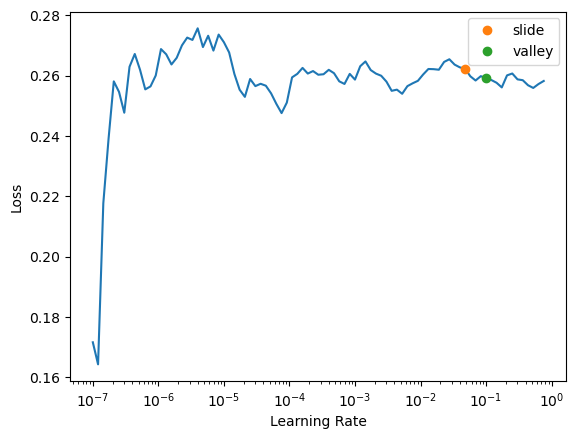

In [107]:
learn.lr_find(suggest_funcs=(slide, valley))

In [108]:
learn.fit(20, lr=0.06)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.237841,0.255403,0.760415,01:00
1,0.262362,0.258417,0.753688,00:59
2,0.256862,0.270894,0.757241,00:59
3,0.261931,0.260178,0.759460,01:00
4,0.262786,0.258288,0.755321,00:57
5,0.263962,0.254300,0.752103,00:59
6,0.252236,0.259148,0.756578,01:00
7,0.241641,0.251884,0.754251,00:59
8,0.253442,0.305918,0.752334,00:59
9,0.233336,0.273764,0.756036,00:59


The model doesn't seem to improve over time, let's increase the complexity

In [116]:
# Neural network with 4 layers of 1000 neurons, with ReLU for hidden layers and sigmoid the final layer

learn_2 = tabular_learner(dls, metrics=score_auc, layers=[1000,1000,1000,1000])

SuggestedLRs(slide=0.019054606556892395, valley=6.30957365501672e-05)

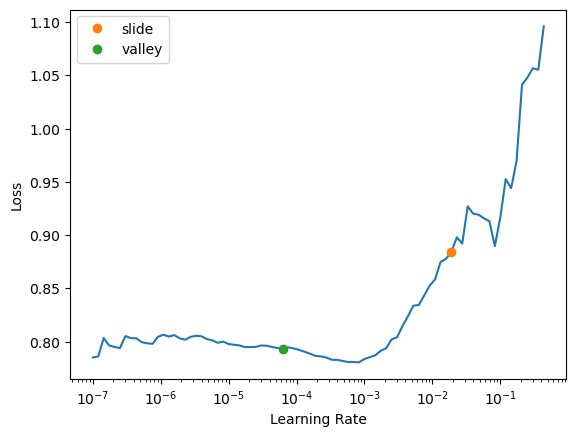

In [117]:
learn_2.lr_find(suggest_funcs=(slide, valley))

In [118]:
learn_2.fit(10, lr=0.001)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.251316,0.253050,0.763220,03:05
1,0.246060,0.244244,0.767249,03:02
2,0.229934,0.254283,0.768114,03:00
3,0.227457,0.249193,0.756246,03:01
4,0.236180,0.252936,0.737640,03:02
5,0.223913,0.276008,0.730849,03:03
6,0.204805,0.290079,0.720266,02:58
7,0.219292,0.315334,0.714800,03:03
8,0.199774,0.452669,0.716147,02:56
9,0.177207,1.059385,0.705969,03:09


We seem to improve our loss for our training set but not the validation so we are probably overfitting the datas

## VIII - Compare <a class="anchor" id="16-bullet"></a>

In [192]:
# Compare scores in this iteration

cv_clfs = {
    'LogisticRegression' : LogisticRegression_clf,
    'RidgeClassifier' : RidgeClassifier_clf,
    'KNeighborsClassifier' : KNeighborsClassifier_clf,
    'LinearSVC' : LinearSVC_clf,
    'SVC' : SVC_clf,
    'DecisionTreeClassifier' : DecisionTreeClassifier_clf,
    'GradientBoostingClassifier' : GradientBoostingClassifier_clf,
    'RandomForestClassifier' : RandomForestClassifier_clf,
    'NeuralNetwork' : nn_clf,
}

iteration_1 = pd.DataFrame()

for key, clf in cv_clfs.items():
    iteration_1[key] = [clf.best_score_, clf.best_params_]
    
iteration_1.index = ['best_score_ : ' + optimized_metric, 'best_params_']

In [193]:
iteration_1

,LogisticRegression,RidgeClassifier,KNeighborsClassifier,LinearSVC,SVC,DecisionTreeClassifier,NeuralNetwork,GradientBoostingClassifier,RandomForestClassifier
best_score_ : roc_auc,0.768526,0.766282,0.609496,0.768407,0.598855,0.540549,0.76431,0.760152,0.670222
best_params_,{'C': 0.1},{'alpha': 10},{'n_neighbors': 10},"{'C': 0.7, 'penalty': 'l2'}",{'C': 0.4},"{'min_samples_leaf': 5, 'min_samples_split': 2}","{'learning_rate': 0.0009729020135732503, 'n_hidden': 0, 'n_neurons': 13.122448979591836}",{'n_estimators': 500},{'n_estimators': 500}


In [197]:
iteration_1.iloc[0].sort_values(ascending=False)

LogisticRegression            0.768526
LinearSVC                     0.768407
RidgeClassifier               0.766282
NeuralNetwork                  0.76431
GradientBoostingClassifier    0.760152
RandomForestClassifier        0.670222
KNeighborsClassifier          0.609496
SVC                           0.598855
DecisionTreeClassifier        0.540549
Name: best_score_ : roc_auc, dtype: object

In [194]:
iteration_1.to_csv('./Scores/iteration_1.csv')

Valeurs testées première itération (cleaned_data_1):
- LogisticRegression : {'C' : np.linspace(0.1, 1, num=4)}, best : C = 0.1 -> tester plus petit
- RidgeClassifier : {'alpha' : np.linspace(1, 10, num=4, dtype=int)}, best : alpha = 10 -> tester plus grand
- KNeighborsClassifier : {'n_neighbors' : np.linspace(3, 10, num=4, dtype=int)}, best : n_neighbors = 10 > tester plus grand
- LinearSVC : {'penalty' : ['l1', 'l2'], 'C' : np.linspace(0.1, 1, num=4)}, bests :
    - C = 0.7 --> tester valeurs autour
    - penalty = l2 --> conserver
- SVC : {'C' : np.linspace(0.1, 1, num=4)}, best : C = 0.4 -> tester valeurs autour
- DecisionTreeClassifier : {'min_samples_split' : [2, 4, 8], 'min_samples_leaf' : [1, 3, 5]}, bests :
    - min_samples_split = 2 --> conserver
    - min_samples_leaf = 5 --> tester plus grand
- GradientBoostingClassifier : {'n_estimators' : [10, 100, 500]}, best : n_estimators = 500 -> tester plus grand
- RandomForestClassifier : {'n_estimators' : [10, 100, 500]}, best : n_estimators = 500 -> tester plus grand